# Task 1 — Data Validation 

This notebook explains the actions I perform, the rationale behind them, and the outcomes produced for an engineering-quality, warranty, and service dataset.

**Input:** `SA - Data for Task 1.xlsx`  
**Records:** **100** | **Columns:** **52**  

---

## Why this matters (business outcome)
Data validation is not “cleanup for cleanup’s sake”. It enables:
- **Reliable issue prioritization** (what fails most / what costs most)
- **Trustworthy trends** (correct dates, consistent categories)
- **Scalable analytics** (automated checks catch regressions early)
- **Better handoffs** between data ops and solution engineering

Each section ends with **Outcome** and **Next action**.


---
## 0) Load data
**Why:** Confirm file shape and quickly inspect schema.

**Outcome:** Detect incomplete exports or schema drift early.


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

in_path = r"data/SA - Data for Task 1.xlsx"
df_raw = pd.read_excel(in_path)
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (100, 52)


,VIN,TRANSACTION_ID,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,REPAIR_DATE,CAUSAL_PART_NM,GLOBAL_LABOR_CODE_DESCRIPTION,PLATFORM,BODY_STYLE,VPPC,...,TRANSMISSION_TRACE_NBR,SRC_TXN_ID,SRC_VER_NBR,TRANSACTION_CNTR,MEDIA_FLAG,VIN_MODL_DESGTR,LINE_SERIES,LAST_KNOWN_DELVRY_TYPE_CD,NON_CAUSAL_PART_QTY,SALES_REGION_CODE
0,3HCFDDE89SH220903,13021,REPLACED STEERING WHEEL NOW OKAY,STEERING WHEEL COMING APART,2024-01-02,WHEEL ASM-STRG *JET BLACK,Steering Wheel Replacement,Full-Size Trucks,Crew Cab,T1CCF,...,S2210121CNJX0941,2808908219,6,1,N,CF10543,1500,21.0,0,1
1,1HRFFEE8XSZ230636,13028,CHECKED - FOUND DTC'S U0229 - U1530 SET IN BCM...,CUSTOMER STATES HEATED STEERING WHEEL INOP,2024-01-03,MODULE ASM-STRG WHL HT CONT,Heated Steering Wheel Module Replacement,Full-Size Trucks,Crew Cab,T1CGF,...,R2210881CNJX0287,2808841910,6,1,Y,TF10543,1500,10.0,0,1
2,1HYKSMRK6SZ000990,13035,APPROVED 4.9(OLH) FOR ADDED DIAGNOSTICS WITH T...,OWNER REPORTS: THE SUPER CRUISE BAR ON THE STE...,2024-01-04,WHEEL ASM-STRG *BACKEN BLACKK,Steering Wheel Replacement,BEV,4 Door Utility,L233-LSOP,...,NaN,2809979441,4,1,Y,6MB26,Lux-1,10.0,0,1
3,3HCFDFEL3SH241701,13021,STEERING WHEEL REPLACEMENT,CUSTOMER STATES THE LETTERING AND FINISH ON TH...,2024-01-04,WHEEL ASM-STRG *JET BLACK,Steering Wheel Replacement,Full-Size Trucks,Crew Cab,T1CCF,...,S1210822CKJX0291,2808892288,6,1,Y,CF10543,1500,10.0,0,1
4,1HRFFHEL1RZ181474,13021,REPLACED STEERING MESSAGE NO LONGER DISPLAYED,C/S: CUSTOMER STATES THE SERVICE DRIVER ASSIST...,2024-01-05,WHEEL ASM-STRG *JET BLACK,Steering Wheel Replacement,Full-Size Trucks,Crew Cab,T1CGF,...,R2212982CKJX0282,2808901882,8,1,N,TF10543,1500,10.0,0,1


---
## 1) Column-wise profile (Data Quality Scan)
**Why:** Quickly identify:
- columns with high missingness
- wrong data types
- ID-like columns vs categorical columns

**Outcome:** You know what is safe to use and what needs escalation.


In [3]:
col_profile = []
for c in df_raw.columns:
    s = df_raw[c]
    col_profile.append({
        "column": c,
        "dtype": str(s.dtype),
        "missing_count": int(s.isna().sum()),
        "missing_pct": round(float(s.isna().mean()*100), 2),
        "unique_values": int(s.nunique(dropna=True)),
        "sample_values": "; ".join(s.dropna().astype(str).head(3).tolist()),
    })
col_profile_df = pd.DataFrame(col_profile).sort_values(["missing_pct","unique_values"], ascending=[False, False])
col_profile_df.head(20)

,column,dtype,missing_count,missing_pct,unique_values,sample_values
31,CAMPAIGN_NBR,float64,100,100.0,0,
40,ENGINE_TRACE_NBR,object,12,12.0,88,V2210281MFTX0488; V2210291MFTX0188; N2210821MF...
42,TRANSMISSION_TRACE_NBR,object,12,12.0,88,S2210121CNJX0941; R2210881CNJX0287; S1210822CK...
39,ENGINE_SOURCE_PLANT,object,12,12.0,9,70628511; 70628511; 830107152
41,TRANSMISSION_SOURCE_PLANT,float64,12,12.0,6,287827.0; 17749294.0; 287827.0
27,OPTN_FAMLY_CERTIFICATION,object,10,10.0,3,FE9; FE9; YF5
5,CAUSAL_PART_NM,object,5,5.0,18,WHEEL ASM-STRG *JET BLACK; MODULE ASM-STRG WHL...
28,OPTF_FAMLY_EMISSIOF_SYSTEM,object,5,5.0,8,FTB; FTB; FF6
19,REPAIR_DLR_POSTAL_CD,object,2,2.0,92,488799101; 557444215; 921083521
17,STATE,object,2,2.0,39,MI; MN; CA


### Outcome insight: Missingness hotspots
|                            |   missing_% |
|:---------------------------|------------:|
| CAMPAIGN_NBR               |         100 |
| ENGINE_TRACE_NBR           |          12 |
| TRANSMISSION_TRACE_NBR     |          12 |
| ENGINE_SOURCE_PLANT        |          12 |
| TRANSMISSION_SOURCE_PLANT  |          12 |
| OPTN_FAMLY_CERTIFICATION   |          10 |
| OPTF_FAMLY_EMISSIOF_SYSTEM |           5 |
| CAUSAL_PART_NM             |           5 |
| LAST_KNOWN_DELVRY_TYPE_CD  |           2 |
| VEH_TEST_GRP               |           2 |

**Interpretation:** columns near 100% missing should be escalated; mid-level missingness might be expected but must be handled explicitly.

**Next action:** Put missingness thresholds into an automated validation pipeline.


---
## 2) Cleaning strategy (Explainable + Auditable)
### Why these steps?
1. **String normalization** → reduces category fragmentation (`'abc'`, `'ABC '`, `' Abc'`).
2. **Date parsing** → enables trends and seasonality analysis.
3. **Numeric coercion** → enables stats and modeling.
4. **Outlier control** → avoids one-off bad points dominating dashboards.
5. **Missing handling** → stable groupbys and model training.

**Outcome:** A stable dataset ready for analytics + ML.


In [4]:
import re

def normalize_text(x):
    if pd.isna(x):
        return ""
    x = str(x).replace("\n"," ").replace("\r"," ")
    x = re.sub(r"\s+", " ", x).strip()
    return x

df = df_raw.copy()

# 1) Standardize text
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    df[c] = df[c].apply(normalize_text)

# 2) Normalize common categoricals (if present)
for c in ["PLATFORM","BODY_STYLE","BUILD_COUNTRY","STATE","FUEL_TYPE","TRANSMISSION","TRANSMISSION_DESC","LINE_SERIES","VIN_MODL_DESGTR"]:
    if c in df.columns:
        df[c] = df[c].str.upper()

# 3) Parse date
if "REPAIR_DATE" in df.columns:
    df["REPAIR_DATE"] = pd.to_datetime(df["REPAIR_DATE"], errors="coerce")

# 4) Convert numeric-like columns safely
for c in df.columns:
    if c == "REPAIR_DATE":
        continue
    if df[c].dtype == "object":
        sample = df[c].dropna().head(50).astype(str)
        if len(sample) > 0 and sample.str.match(r"^-?\d+(\.\d+)?$").mean() > 0.8:
            df[c] = pd.to_numeric(df[c], errors="coerce")

df.dtypes

VIN                                      object
TRANSACTION_ID                            int64
CORRECTION_VERBATIM                      object
CUSTOMER_VERBATIM                        object
REPAIR_DATE                      datetime64[ns]
CAUSAL_PART_NM                           object
GLOBAL_LABOR_CODE_DESCRIPTION            object
PLATFORM                                 object
BODY_STYLE                               object
VPPC                                     object
PLANT                                    object
BUILD_COUNTRY                            object
LAST_KNOWN_DLR_NAME                      object
LAST_KNOWN_DLR_CITY                      object
REPAIRING_DEALER_CODE                    object
DEALER_NAME                              object
REPAIR_DLR_CITY                          object
STATE                                    object
DEALER_REGION                             int64
REPAIR_DLR_POSTAL_CD                    float64
REPAIR_AGE                              

### Outcome check: Missingness before vs after cleaning
**Why:** parsing can create new NaNs (invalid dates/numbers).

**Outcome:** Confidence that cleaning didn't silently destroy data.


In [5]:
before = df_raw.isna().mean().sort_values(ascending=False)*100
after = df.isna().mean().sort_values(ascending=False)*100
compare = pd.DataFrame({"missing_before_%": before, "missing_after_%": after}).fillna(0)
compare.sort_values("missing_after_%", ascending=False).head(15)

,missing_before_%,missing_after_%
CAMPAIGN_NBR,100.0,100.0
ENGINE_SOURCE_PLANT,12.0,17.0
REPAIR_DLR_POSTAL_CD,2.0,14.0
TRANSMISSION_SOURCE_PLANT,12.0,12.0
LAST_KNOWN_DELVRY_TYPE_CD,2.0,2.0
BUILD_COUNTRY,0.0,0.0
CAUSAL_PART_NM,5.0,0.0
COMPLAINT_CD_CSI,0.0,0.0
CUSTOMER_VERBATIM,0.0,0.0
DEALER_NAME,0.0,0.0


---
## 3) Outlier control (Winsorization)
**Why:** prevents extreme values from dominating trends.

**Outcome:** stable aggregates and better ML baselines.


In [6]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
id_like = {"TRANSACTION_ID","SRC_TXN_ID","ENGINE_TRACE_NBR","TRANSMISSION_TRACE_NBR","GLOBAL_LABOR_CODE",
           "ORD_SELLING_SRC_CD","SRC_VER_NBR","TRANSACTION_CNTR","COMPLAINT_CD_CSI"}
cap_cols = [c for c in num_cols if c not in id_like]

outlier_report = []
for c in cap_cols:
    x = df[c]
    if x.isna().all():
        continue
    q1, q99 = x.quantile(0.01), x.quantile(0.99)
    capped = int(((x < q1) | (x > q99)).sum())
    df[c] = x.clip(q1, q99)
    outlier_report.append({"column": c, "p01": q1, "p99": q99, "capped_values": capped})

pd.DataFrame(outlier_report).sort_values("capped_values", ascending=False).head(10)

,column,p01,p99,capped_values
1,REPAIR_DLR_POSTAL_CD,3.230860e+04,9.755881e+08,2
3,KM,7.950000e+00,8.107600e+04,2
5,TOTALCOST,3.156090e+01,1.727776e+03,2
4,REPORTING_COST,3.006600e+01,1.720296e+03,2
6,LBRCOST,2.290070e+01,5.051960e+02,2
2,REPAIR_AGE,0.000000e+00,4.901000e+01,1
8,TRANSMISSION_SOURCE_PLANT,2.878270e+05,8.236653e+08,1
7,ENGINE_SOURCE_PLANT,1.744270e+06,8.301072e+08,1
0,DEALER_REGION,1.000000e+00,4.000000e+00,0
9,LAST_KNOWN_DELVRY_TYPE_CD,1.000000e+01,3.700000e+01,0


---
## 4) Missing handling
**Why:** groupby and ML pipelines need consistent values.
- Categorical → `UNKNOWN`
- Numeric metrics → median
- ID-like columns → keep missing

**Outcome:** dataset becomes “analysis-safe”.


In [7]:
for c in df.columns:
    if c == "REPAIR_DATE":
        continue
    if df[c].dtype == "object":
        df[c] = df[c].replace("", np.nan).fillna("UNKNOWN")
    elif pd.api.types.is_numeric_dtype(df[c]):
        if c in id_like:
            continue
        df[c] = df[c].fillna(df[c].median())

df.isna().mean().sort_values(ascending=False).head(10)

C:\Users\pureai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


CAMPAIGN_NBR                     1.0
VIN                              0.0
CORRECTION_VERBATIM              0.0
TRANSACTION_ID                   0.0
REPAIR_DATE                      0.0
CAUSAL_PART_NM                   0.0
GLOBAL_LABOR_CODE_DESCRIPTION    0.0
PLATFORM                         0.0
BODY_STYLE                       0.0
VPPC                             0.0
dtype: float64

---
## 5) Critical columns (Top 5) + rationale
- `CAUSAL_PART_NM` → what failed
- `GLOBAL_LABOR_CODE_DESCRIPTION` → what work was done
- `REPAIR_DATE` → when (trend)
- `PLATFORM` → where (product family)
- `TOTALCOST` → business impact

**Outcome:** With these alone you can build a useful issue dashboard.


---
## 6) Visuals that lead to decisions
**Outcome:** Identify *what* to prioritize and *where* it is concentrated.


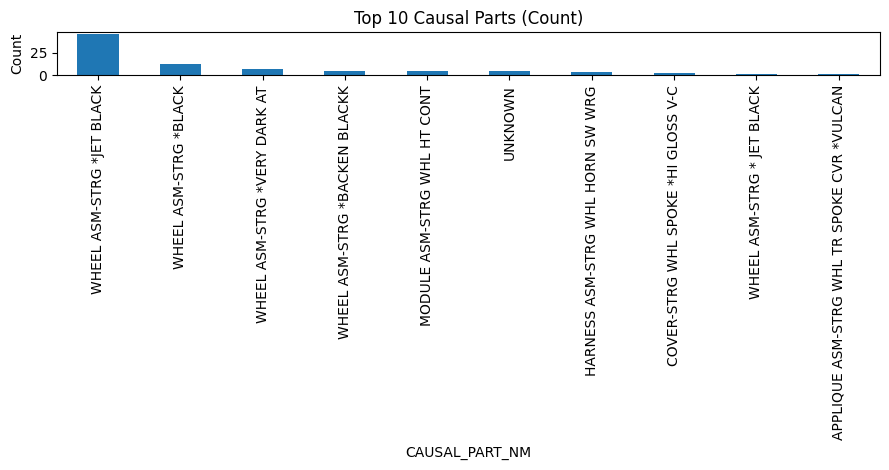

In [8]:
# Plot 1: Top causal parts
if "CAUSAL_PART_NM" in df.columns:
    plt.figure(figsize=(9,4.8))
    df["CAUSAL_PART_NM"].value_counts().head(10).plot(kind="bar")
    plt.title("Top 10 Causal Parts (Count)")
    plt.xlabel("CAUSAL_PART_NM")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

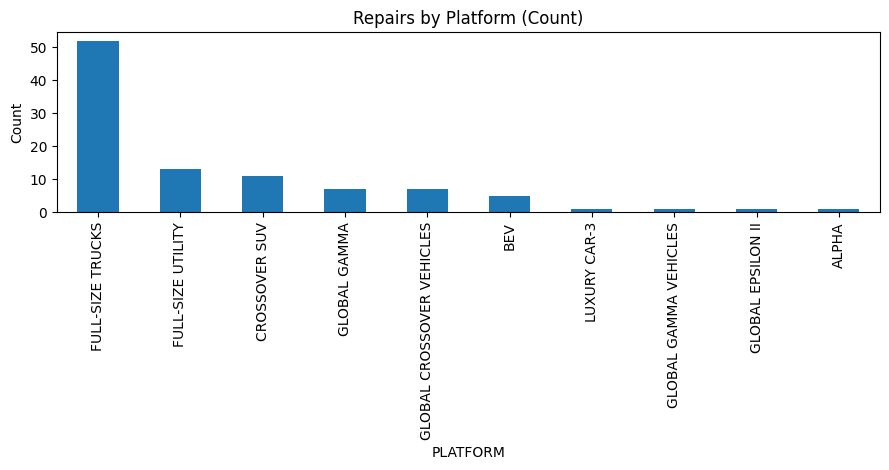

In [9]:
# Plot 2: Repairs by platform
if "PLATFORM" in df.columns:
    plt.figure(figsize=(9,4.8))
    df["PLATFORM"].value_counts().head(10).plot(kind="bar")
    plt.title("Repairs by Platform (Count)")
    plt.xlabel("PLATFORM")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

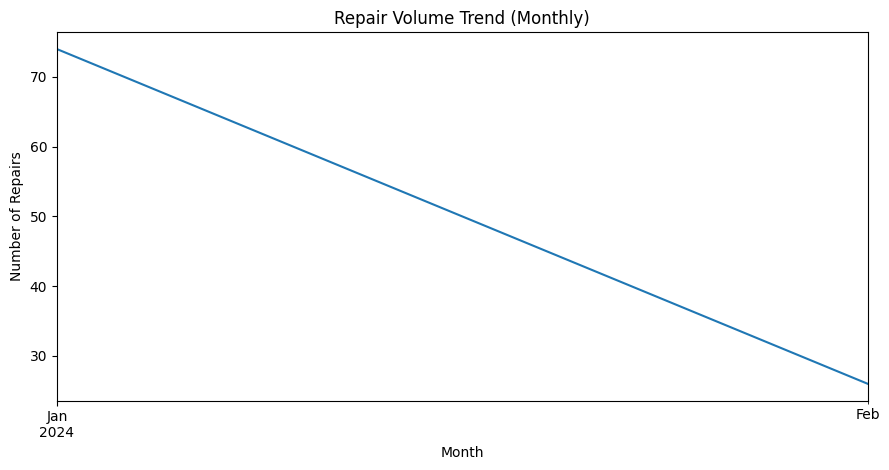

In [10]:
# Plot 3: Monthly trend
if "REPAIR_DATE" in df.columns and df["REPAIR_DATE"].notna().any():
    plt.figure(figsize=(9,4.8))
    monthly = df.set_index("REPAIR_DATE").resample("MS").size()
    monthly.plot(kind="line")
    plt.title("Repair Volume Trend (Monthly)")
    plt.xlabel("Month")
    plt.ylabel("Number of Repairs")
    plt.tight_layout()
    plt.show()

### Outcome insights from visuals
**Top causal parts (count):**

| CAUSAL_PART_NM                                |   count |
|:----------------------------------------------|--------:|
| WHEEL ASM-STRG *JET BLACK                     |      45 |
| WHEEL ASM-STRG *BLACK                         |      12 |
| WHEEL ASM-STRG *VERY DARK AT                  |       7 |
| WHEEL ASM-STRG *BACKEN BLACKK                 |       5 |
| MODULE ASM-STRG WHL HT CONT                   |       5 |
| HARNESS ASM-STRG WHL HORN SW WRG              |       4 |
| COVER-STRG WHL SPOKE *HI GLOSS V-C            |       3 |
| APPLIQUE ASM-STRG WHL TR SPOKE CVR *SYNTHESIS |       2 |
| WHEEL ASM-STRG * JET BLACK                    |       2 |
| APPLIQUE ASM-STRG WHL TR SPOKE CVR *VULCAN    |       2 |


**Top platforms (count):**

| PLATFORM                  |   count |
|:--------------------------|--------:|
| Full-Size Trucks          |      52 |
| Full-Size Utility         |      13 |
| Crossover SUV             |      11 |
| Global Crossover Vehicles |       7 |
| Global Gamma              |       7 |
| BEV                       |       5 |
| Luxury Car-3              |       1 |
| Global Gamma Vehicles     |       1 |
| GLOBAL EPSILON II         |       1 |
| Alpha                     |       1 |


**Date range:** 2024-01-02 → 2024-02-07

**Peak month:** 2024-01-01 with **74 repairs**

**Next action:** Start triage with (Top Parts × Top Platforms), then add cost lens below.


---
## 7) Free-text → Tags (structured signals)
**Why:** Verbatims contain symptoms/actions. Tags allow aggregation without manual reading.

Adds new columns:
- `TAG_COMPONENTS`
- `TAG_CONDITIONS`
- `TAG_ACTIONS`
- `TAG_KEYWORDS`

**Outcome:** You can build symptom/component dashboards and create ML features.


In [11]:
STOPWORDS = set("""a an the and or but if while with without within into onto of for from to in on at by as is are was were be been being
this that these those it its it's i me my we our you your they their he she his her them us
found check checked verify verified performed perform performe replace replaced replacement install installed remove removed
repaired repair reprogram programmed program update updated reset cleared clear
no not now ok okay issue concern customer vehicle car""".split())

COMPONENT_PATTERNS = {
    "STEERING": [r"\bsteer", r"\bsteering\b", r"\bwheel\b", r"\brack\b"],
    "BRAKES": [r"\bbrake", r"\babs\b"],
    "TRANSMISSION": [r"\btrans", r"\bgear", r"\bshift"],
    "ENGINE": [r"\bengine\b", r"\bmisfire\b", r"\bcoil\b", r"\bspark\b"],
    "ELECTRICAL": [r"\bbcm\b", r"\becm\b", r"\bpcm\b", r"\bmodule\b", r"\bsensor\b", r"\bwiring\b", r"\bconnector\b"],
    "INFOTAINMENT": [r"\bradio\b", r"\bdisplay\b", r"\bscreen\b", r"\bcarplay\b", r"\bandroid\b"],
    "HVAC": [r"\bac\b", r"\bblower\b", r"\bheater\b", r"\bhvac\b"],
    "SUSPENSION": [r"\bshock\b", r"\bstrut\b", r"\bbushing\b", r"\bsuspension\b"],
    "BATTERY": [r"\bbattery\b", r"\b12v\b", r"\bvolt\b"],
    "DOOR/TRIM": [r"\bdoor\b", r"\btrim\b", r"\bpanel\b"],
}

CONDITION_PATTERNS = {
    "NOISE/RATTLE": [r"\brattle\b", r"\bnoise\b", r"\bsqueak\b", r"\bcreak\b", r"\bclunk\b"],
    "LEAK": [r"\bleak\b", r"\bseep\b", r"\bfluid\b"],
    "WARNING/LIGHT": [r"\blight\b", r"\bwarning\b", r"\bmessage\b", r"\bindicator\b"],
    "DTC/CODE": [r"\bdtc\b", r"\bu\d{4}\b", r"\bp\d{4}\b", r"\bc\d{4}\b", r"\bcode\b"],
    "NOT WORKING": [r"\bnot work", r"\bdoesn'?t work\b", r"\binop\b", r"\bfail\b", r"\bfailed\b"],
    "VIBRATION": [r"\bvibration\b", r"\bshake\b"],
}

ACTION_PATTERNS = {
    "REPLACE": [r"\breplace", r"\breplaced\b", r"\breplacement\b"],
    "REPAIR": [r"\brepair", r"\brepaired\b", r"\bfixed\b"],
    "INSPECT/DIAG": [r"\bdiagn", r"\binspect", r"\bcheck", r"\btested\b", r"\bscan\b"],
    "REPROGRAM/UPDATE": [r"\breprogram", r"\bprogram", r"\bupdate", r"\bcalibrat"],
    "CLEAN/ADJUST": [r"\bclean", r"\badjust", r"\btighten", r"\blube", r"\blower"],
}

def extract_keywords(text, max_k=8):
    text = normalize_text(text).lower()
    tokens = re.findall(r"[a-z0-9']+", text)
    toks = [t for t in tokens if len(t) > 2 and t not in STOPWORDS and not t.isdigit()]
    if not toks:
        return []
    return pd.Series(toks).value_counts().head(max_k).index.tolist()

def match_tags(text, patterns_dict):
    t = normalize_text(text).lower()
    tags = []
    for tag, pats in patterns_dict.items():
        if any(re.search(p, t) for p in pats):
            tags.append(tag)
    return tags

combined_text = (
    df.get("CUSTOMER_VERBATIM","").astype(str) + " " +
    df.get("CORRECTION_VERBATIM","").astype(str) + " " +
    df.get("GLOBAL_LABOR_CODE_DESCRIPTION","").astype(str) + " " +
    df.get("CAUSAL_PART_NM","").astype(str)
)

df["TAG_COMPONENTS"] = combined_text.apply(lambda t: ", ".join(match_tags(t, COMPONENT_PATTERNS)))
df["TAG_CONDITIONS"] = combined_text.apply(lambda t: ", ".join(match_tags(t, CONDITION_PATTERNS)))
df["TAG_ACTIONS"] = df.get("CORRECTION_VERBATIM","").astype(str).apply(lambda t: ", ".join(match_tags(t, ACTION_PATTERNS)))
df["TAG_KEYWORDS"] = combined_text.apply(lambda t: ", ".join(extract_keywords(t, max_k=8)))

df[["CUSTOMER_VERBATIM","CORRECTION_VERBATIM","TAG_COMPONENTS","TAG_CONDITIONS","TAG_ACTIONS","TAG_KEYWORDS"]].head(10)

,CUSTOMER_VERBATIM,CORRECTION_VERBATIM,TAG_COMPONENTS,TAG_CONDITIONS,TAG_ACTIONS,TAG_KEYWORDS
0,STEERING WHEEL COMING APART,REPLACED STEERING WHEEL NOW OKAY,STEERING,,REPLACE,"wheel, steering, coming, apart, asm, strg, jet..."
1,CUSTOMER STATES HEATED STEERING WHEEL INOP,CHECKED - FOUND DTC'S U0229 - U1530 SET IN BCM...,"STEERING, ELECTRICAL","DTC/CODE, NOT WORKING","REPLACE, INSPECT/DIAG","module, heated, wheel, steering, tested, inop,..."
2,OWNER REPORTS: THE SUPER CRUISE BAR ON THE STE...,APPROVED 4.9(OLH) FOR ADDED DIAGNOSTICS WITH T...,STEERING,,"REPLACE, INSPECT/DIAG, REPROGRAM/UPDATE","wheel, steering, tcsc, programming, case, driv..."
3,CUSTOMER STATES THE LETTERING AND FINISH ON TH...,STEERING WHEEL REPLACEMENT,STEERING,,REPLACE,"wheel, steering, states, finish, lettering, co..."
4,C/S: CUSTOMER STATES THE SERVICE DRIVER ASSIST...,REPLACED STEERING MESSAGE NO LONGER DISPLAYED,STEERING,WARNING/LIGHT,REPLACE,"message, wheel, steering, driver, assist, serv..."
5,Horn and steering wheel switches are inoperable,Remove and replace steering wheel wire harness,"STEERING, ELECTRICAL",,REPLACE,"horn, steering, wheel, harness, switches, inop..."
6,CUST. STATES DRIVERS ASSIST LIGHT COMES ON DAS...,"ACCESSED, REMOVED AND REPLACED THE DRIVERS ASS...","STEERING, ELECTRICAL","WARNING/LIGHT, DTC/CODE","REPLACE, INSPECT/DIAG, REPROGRAM/UPDATE","drivers, accessed, wheel, assist, states, cust..."
7,Special Order Part [ steering wheel heated ste...,REPLACED STEERING WHEEL,STEERING,NOT WORKING,REPLACE,"wheel, steering, special, part, order, heated,..."
8,CUSTOMER STATES STEERING WHEEL IS MAKING A RUB...,TECHNICIAN FOUND THE STEERING COLUMN PLASTIC T...,"STEERING, DOOR/TRIM",NOISE/RATTLE,CLEAN/ADJUST,"steering, wheel, trim, states, rubbing, making..."
9,Customer states that they are getting a messag...,Steering Wheel Replacement,STEERING,WARNING/LIGHT,REPLACE,"wheel, message, steering, dash, getting, state..."


---
## 8) Outcome lens: Cost impact (if TOTALCOST exists)
**Why:** frequency ≠ impact. Some rare issues cost more.

**Outcome:** prioritize by money saved.


In [12]:
if "TOTALCOST" in df.columns and pd.api.types.is_numeric_dtype(df["TOTALCOST"]):
    df["TOTALCOST"].describe()
else:
    print("TOTALCOST not numeric/available.")

In [13]:
if "TOTALCOST" in df.columns and pd.api.types.is_numeric_dtype(df["TOTALCOST"]) and "CAUSAL_PART_NM" in df.columns:
    (df.groupby("CAUSAL_PART_NM")["TOTALCOST"]
      .agg(["count","mean","median","sum"])
      .sort_values("sum", ascending=False)
      .head(10))
else:
    print("Need numeric TOTALCOST + CAUSAL_PART_NM.")

---
## 9) Export outputs
**Outcome:** you get a clean dataset for dashboards/ML and a reproducible pipeline.


In [15]:
out_csv = "task1_cleaned_tagged_outcome_oriented.csv"
out_xlsx = "task1_cleaned_tagged_outcome_oriented.xlsx"
df.to_csv(out_csv, index=False)
df.to_excel(out_xlsx, index=False)
print("Saved:", out_csv, out_xlsx)

Saved: task1_cleaned_tagged_outcome_oriented.csv task1_cleaned_tagged_outcome_oriented.xlsx


---
## 10) Now this dataset is now ready for

- Failure dashboards (by component / platform / condition)

- Cost prioritization (TOTALCOST × component / platform)

- ML feature input (tags + numeric metrics)

- Trend analysis (monthly / seasonal issues)

- LLM / NLP pipelines (tags as weak labels)